# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw

https://www.kaggle.com/seesea0203/segmented-train-seg-by-word
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [11]:
# segmented_train_seg_by_word.txt 内容sample
# couple of what ? who ' s buddy ?
#一对 什么 ？ 哥们儿 是 谁 ？ 

! wc -l data/segmented_train_seg_by_word.txt

 20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [12]:
from utils import ProgressBar
import numpy as np

In [13]:
str = "一对 丹顶鹤 正 监视 着 它们 的 筑巢 领地"
test = [i for i in str.strip("\n").replace(' ','')]
print(test)

['一', '对', '丹', '顶', '鹤', '正', '监', '视', '着', '它', '们', '的', '筑', '巢', '领', '地']


In [14]:
enline = None
chline = None

sentlength = 5

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
# 中文， 英文 分类， 只留下长度 <=5的句子
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        
        """
            text_classify_basic里, chlinesp是split成每个单词. 而这里是split成每个字
            "一对 丹顶鹤 正 监视 着 它们 的 筑巢 领地" -> 
            ['一', '对', '丹', '顶', '鹤', '正', '监', '视', '着', '它', '们', '的', '筑', '巢', '领', '地']
        """
        chlinesp = [i for i in chline.strip("\n").replace(' ','')]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
        

 100.00 % [==================================================>] 10000000/10000000 	 used:50s eta:0 s

In [15]:
enlines[:5]

[['deuces', 'the', 'winner', '.'],
 ['a', 'couple', 'of', 'what', '?'],
 ['a', 'pair', 'of', 'wives', '?'],
 ['husband', 'and', 'wife', '.'],
 ['couple', '.']]

In [16]:
chlines[:5] #中文这里 用每个字 而不是单词

[['一', '对', '二', '胜', '。'],
 ['一', '对', '什', '么', '？'],
 ['一', '对', '太', '太', '？'],
 ['一', '对', '夫', '妇', '。'],
 ['一', '对', '夫', '妻', '。']]

In [17]:
len(chlines),len(enlines)

(103912, 103912)

In [18]:
# text_classify_basic.ipynb 里，只用了一个叫 words[]的数组， 这里中英文单词分开存储
enwords = [] 
chwords = []
for sent in enlines:
    for enword in sent:
        enwords.append(enword)
        
for sent in chlines:
    for chword in sent:
        chwords.append(chword)
    

In [19]:
from collections import Counter

In [20]:
Counter(enwords).most_common(10)

[('.', 49461),
 ('?', 14511),
 ('the', 10472),
 ('i', 10013),
 (',', 9489),
 ('!', 8807),
 ('you', 7493),
 ('a', 6860),
 ("'", 5555),
 ('it', 5524)]

In [21]:
Counter(chwords).most_common(10)

[('。', 44900),
 ('我', 15087),
 ('？', 14454),
 ('你', 9087),
 ('！', 8915),
 ('了', 8663),
 ('的', 8053),
 ('，', 7291),
 ('一', 6091),
 ('是', 5946)]

In [22]:
len(enwords),len(chwords)

(405184, 496885)

In [23]:
len(set(enwords)),len(set(chwords)) # use SET to remove duplicated words

(21739, 4054)

In [24]:
# text_classify_basic.ipynb 里，word2ind, ind2word两个数组.这里中英文分开处理
ch2ind = {}
ind2ch = {}
en2ind = {}
ind2en = {}

In [25]:
specialchars = ['<eos>','<start>','<end>','<unk>'] # text_classify_basic.ipynb 里 只有 '<pad>','<unk>'

In [26]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [27]:
# 把special char 往中英文数组里各加入一份
for one in specialchars:
    addchar(ch2ind,ind2ch,one)
    addchar(en2ind,ind2en,one)
print("中文:", ch2ind, ind2ch)
print("英文:", en2ind, ind2en)

中文: {'<eos>': 0, '<start>': 1, '<end>': 2, '<unk>': 3} {0: '<eos>', 1: '<start>', 2: '<end>', 3: '<unk>'}
英文: {'<eos>': 0, '<start>': 1, '<end>': 2, '<unk>': 3} {0: '<eos>', 1: '<start>', 2: '<end>', 3: '<unk>'}


In [28]:
# 只对 enwords 和 chwords 出现频率最高的前10000单词 构建 <word, index> <index, word>映射 词典
for word,_ in Counter(enwords).most_common(10000):
    addchar(en2ind,ind2en,word)
    
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

In [29]:
len(en2ind),len(ch2ind)

(10004, 4058)

### Prepare 左半边encoder & 右半边decoder 网络的输入 输出

In [30]:
"""
    text_classify_basic.ipynb 
        1. 完成中英文句子分类任务
        2. 只有 dat_x_in = []， dat_y = []两个数组， 
    seq2seq_basic.ipynb 
        1. 完成将输入英文 翻译 成 中文的任务
        2. 这里dat_y 分为 dat_y_in，dat_y_out
    
"""

dat_x_in = []
dat_x_len = []

# dat_y_in:  对应PPT中 RNN NMT Training 结构图中右半边decoder图中, 上面的 “target y1, target y2, <end> ”
# dat_y_out: 对应PPT中 RNN NMT Training 结构图中右半边decoder图中, 下面bottom部分的“<start>,  target y1, target y2”
dat_y_in = []
dat_y_out = []

# 因为 dat_y_in[]， dat_y_out[] 里每个句子长度一样(其实是一样的句子，只是dat_y_in句子前面加了个<start>, dat_y_out句子结尾加了个<end>)
# 所以一样长，这里只用一个统一的数组dat_y_len 来track 长度就可以
dat_y_len = [] 


# 结合PPT, 对应 RNN NMT structure 左半边图，相当于 source langage 英文
for ensent in enlines:
    indsent = [en2ind.get(i,en2ind['<unk>']) for i in ensent] # 英语句子里每个单词 --> index, 然后放入indsent. indsent里是用数字index表示的句子
    indsent.append(en2ind['<eos>']) #以句子为单位，将当前句子里每个词装换成index 结果加上eos特殊符号的index(i.e. 0)
    
    dat_x_in.append(indsent) #放入dat_x_in数组. 数组dat_x_in[] 里每一个元素大概这样： [3, 6, 2730, 4, 0]
    dat_x_len.append(len(indsent)) # 每个英文句子的实际长度（包含最后一个字符<eos>）存下来
    
# 结合PPT, 对应 RNN NMT structure 右半边图, 相当于 target langage (i.e. 输入英文被翻译为中文) 
for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    
    #相比较:dat_x_in数组里，每个用index表示的英文句子结尾只加了一个eos特殊符号。
    dat_y_in.append([ch2ind['<start>']] + indsent) #dat_y_in里每个元素： [1, 12, 63, 582, 901, 4] 1 就是start的index
    dat_y_out.append(indsent + [ch2ind['<end>']]) # dat_y_out里每个元素： [12, 63, 582, 901, 4, 2] 2 就是end的index
    
    dat_y_len.append(len(indsent) + 1) # ??? 为什么这里中文句子长度加1？ 中文句子长度加1是考虑到了末尾符号

In [31]:
[ind2en[i] for i in dat_x_in[4]]

['couple', '.', '<eos>']

In [32]:
[ind2ch[i] for i in dat_y_in[4]]

['<start>', '一', '对', '夫', '妻', '。']

In [33]:
[ind2ch[i] for i in dat_y_out[4]]

['一', '对', '夫', '妻', '。', '<end>']

In [34]:
dat_x_in[4], dat_y_in[4], dat_y_out[4]

([260, 4, 0], [1, 12, 63, 434, 1073, 4], [12, 63, 434, 1073, 4, 2])

In [35]:
dat_x_len[4],dat_y_len[4]

(3, 6)

In [36]:
len(dat_x_in),\
len(dat_y_in),\
len(dat_y_out),\
len(dat_x_len),\
len(dat_y_len)

(103912, 103912, 103912, 103912, 103912)

# MODEL PART
![title](img/seq2seq_train.png)

In [37]:
from tensorflow.python.layers import core as layers_core

In [38]:
import tensorflow as tf
# import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [39]:
embedding_size = 512 # 单词的embedding表的列数. 相当于把每个单词映射为512维的向量 i.e.（1 * 512）

"""
    num_units = 512 Hyper parameter. 是隐变量c的维度. 也就是每个RNN cell 的输出维度
    Note: 
        RNN NMT 结构中，左边endocer公用一个RNN(虽然结构图里画了3个box,其实就是一个共享权重的RNN)，同理右半边decoder网络也是。
        但是左边 和右边 的两个RNN 并不共享网络权重参数

    在text_classfify任务的的时候，老师课上解释： RNN->S1->RNN->S2...这里的512就是就是S1的大小，也就是hidden unit memory 的大小
    512个float -> 512 * 32bit (i.e. 512 * 4字节)
   
    在LSTM里：相当于Ct(长期记忆)和Ht（短期记忆）都是num_unit个浮点数， 也就是memory size. 在标准的RNN里就是是S1, S2 等这些状态的memeory size. 

"""
num_units = 512 # 助教回答：是隐变量c的维度。 然后embedding size是word经过embedding后的维度。所以矩阵W的维度应该是1024*512
batch_size = 128
layer_number = 2 #这里代码用了1层的双向RNN，所以layer是2. 对应PPT Week12.Session1.RNN-NMT_v1.1.pdf第20页双向RNN图比较好理解
max_grad = 1.0 # 梯度裁剪 PPT里有提到， 对应裁剪阀值c
dropout = 0.2
src_vocab_size = len(en2ind) # 英语 -> 中文，这里是输入英语词汇表的大小
target_vocat_size = len(ch2ind) # 英语 -> 中文，这里是输出中文词汇表的大小


seq_max_len = sentlength + 1 # sentlength 上面定义过了是5  ???为什么加1 表示什么意思

"""
    老师课上提到是解码的时候最长可以输出多长 (对应课件PPT Week12.Session1.RNN-NMT_v1.1.pdf 7页 seq2seq 机器翻译训练)
    右上角的<end> end 是一种结束解码的方式. 也可以用maximum_iterations, 
    代码里已经用了<end>，这里这个变量可以防止句子过长,也就是解码序列超过这个值，后面的就不处理了
""" 
maximum_iterations = 10

In [40]:

tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    # all of the LSTM's parameters with the uniform distribution between -0.08 and 0.08
    initializer = tf.random_uniform_initializer(-0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    
    x = tf.placeholder("int32", [None, None]) # batch_size，  time_step (每个词) batch_size 就是多少句话，time_step就是每句话里多少个单词
    y = tf.placeholder("int32", [None, None]) # dat_y_out 二维的  右半边结构图 上面的target y1, target y2
    y_in = tf.placeholder("int32",[None,None]) # dat_y_in 二维的 右半边结构图 下面的target y1, target y2
    
    x_len = tf.placeholder("int32",[None])
    y_len = tf.placeholder("int32",[None])
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # buid embedding table
    #text_classify_basic.ipynb仅定义了embedding_encoder， 这里翻译任务 还定义了 embedding_decoder
    embedding_encoder = tf.get_variable("embedding_encoder", [src_vocab_size, embedding_size],dtype=tf.float32)
    embedding_decoder = tf.get_variable("embedding_decoder", [target_vocat_size, embedding_size],dtype=tf.float32)

    
    # actualy do the embedding by lookup above built embedding tables
    encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, x) #对应RNN NMT strcuture 图里的左半边：把输入待翻译的句子X映射成embedding后的编码向量
     # y_in 对应PPT RNN NMT train结构图右半边图的最下方的输入 <start>, target y1, target y2，相当于实际的我想要的预测结果label. 只有在training 的时候有输入. predict的阶段没有该输入
    decoder_emb_inp = tf.nn.embedding_lookup(embedding_decoder, y_in) # 对应RNN NMT strcuture 图里的右半边：把y_in映射成embedding后的编码向量
    
    # ??? encoder ...这个项目里没有用到，PPT 附录里GNMT 论文里有用到.
    # 这里代码用了1层的双向RNN，所以layer是2. 对应PPT Week12.Session1.RNN-NMT_v1.1.pdf第20页双向RNN图比较好理解
    num_bi_layers = int(layer_number / 2)
    
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)   # Build encoder RNN cell

    # Run Dynamic RNN NMT结构中的左半边的RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units] 左半边encoding 图最后的输出， 该输出要输入到右半边的decoder图中
    # batch_size就是每个句子， time_step: 就是每个词
    # 譬如两句话  我吃米。 米好吃。 可以把两句话第一个词 （我， 米）同时送进去RNN训练
    # 左半边的训练
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, encoder_emb_inp,sequence_length=x_len, time_major=False,dtype=tf.float32)
    print("encoder_outputs",  encoder_outputs) # shape=(?, ?, 50)
    print("encoder_state", encoder_state) # shape=(?, 50)
        
    batch_size_in = tf.shape(x)[0] # 每个batch, 多少个setences.也就是 x的shape[0]
    # 事先声明的dense 也就是fully connected layer， PPT右半边图中紫色全连接的框
    # projection_layer: 对应右半边FC层的输出（PPT中紫红色的框）. ch2ind: dict type. 也就是target中文的词汇表对应的index
    # ???
    projection_layer = layers_core.Dense(len(ch2ind), use_bias=False) #对比text_classify: model_logistic = tf.layers.dense(encoder_state[0],1) 
    
    # Dynamic decoding
    with tf.variable_scope("decode_layer"):
        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units) # Build decoder RNN cell
        helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb_inp, y_len, time_major=False)# Helper 用来接收RNN NMT结构图中右半边图中的y_in
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, encoder_state,output_layer=projection_layer)
        # Dynamic decoding(training  阶段的 decode)
        outputs, _ , __ = tf.contrib.seq2seq.dynamic_decode(decoder)
        # 对应PPT 中softmax页面， RNN 每个时间片都输出logits
        # RNN 在training 阶段 的每个时间片（i.e. time_step 也就是每个单词）都会输出logits， logits 也就是  预测的值
        logits = outputs.rnn_output # train 阶段 红色框 predict 
        # seq_max_len 对应PPT 15页中，batch里每个sequence的max length
        # tf.sequence_mask 函数就可以帮你生成PPT page 16里的mask
        # target_weights就是PPT中提到的mask矩阵
        target_weights = tf.sequence_mask(y_len, seq_max_len, dtype=logits.dtype)
    
    # predicting 参考PPT里预测的网络结构
    # Helper  训练 预测 共享网络参数
    # variable_scope reuse=True的设置， 就可以在predicting 阶段共享training参数
    with tf.variable_scope("decode_layer", reuse=True):
        # ???
        helper = tf.contrib.seq2seq.GreedyEmbeddingHelper( embedding_decoder,tf.fill([batch_size_in], ch2ind['<start>']), ch2ind['<end>'])

        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, encoder_state, output_layer=projection_layer)
        # Dynamic decoding
        outputs, _ , __= tf.contrib.seq2seq.dynamic_decode(decoder, maximum_iterations=maximum_iterations)
        translations = outputs.sample_id
        

    # calculate loss
    # sparse_softmax 可以加速运算
    # 基于PPT16 页， 去计算training 阶段的loss， 是基于训练时候每个时间片(time_step)输出的logits计算的
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    # 上面也就是那预测的值logits 和lable y去计算sparse_softmax_cross_entropy
    #??? 分母中是一个batch里多少句话？？batch_size_in 为什么要除以这个？
    # 论文里也有说呀，是把梯度除了batch_size等效于loss除batch_size. target_weights就是PPT中提到的mask矩阵
    train_loss = (tf.reduce_sum(crossent * target_weights) / tf.cast(batch_size_in,tf.float32))
    
    optimizer_ori = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    trainable_params = tf.trainable_variables()
    gradients = tf.gradients(train_loss, trainable_params)
    # clip 就是梯度裁剪
    clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = optimizer_ori.apply_gradients(
            zip(clip_gradients, trainable_params), global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(train_loss)
    #trainop = tflearn.TrainOp(loss=train_loss, optimizer=optimizer,
    #                          metric=train_loss, batch_size=64)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
encoder_outputs Tensor("rnn/transpose_1:0", shape=(?, ?, 512), dtype=float32, device=/device:GPU:1)
encoder_state LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 512) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 512) dtype=float32>)


In [41]:
session.run(tf.global_variables_initializer())

In [42]:
session.run(encoder_emb_inp,feed_dict={x:np.asarray(dat_x_in[:1])}).shape

(1, 5, 512)

In [43]:
# padding  把每个batch 里 长度不一样的句子padding成一样长的，以最长的句子为标准， 不够长的在末尾补<eos> OR <end>
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=en2ind['<eos>'])
dat_y_in = tf.keras.preprocessing.sequence.pad_sequences(dat_y_in,padding='post',value=en2ind['<end>'])
dat_y_out = tf.keras.preprocessing.sequence.pad_sequences(dat_y_out,padding='post',value=en2ind['<end>'])

dat_x_len = np.asarray(dat_x_len)
dat_y_len = np.asarray(dat_y_len)

In [44]:
dat_x_in.shape,dat_y_in.shape,dat_y_out.shape,dat_x_len.shape,dat_y_len.shape

((103912, 6), (103912, 6), (103912, 6), (103912,), (103912,))

## Training PART

In [46]:
losses = []
beginning_lr = 4
for one_epoch in range(0,1):
    index = np.asarray(list(range(len(dat_x_in)))) # index [0,1,2,3.........10000] (the size of dat_x_in)
    np.random.shuffle(index) # 每一个epoch，开始时候，都shuffle一下
    pb = ProgressBar(worksum=len(index)) # 每一个epoch，开始时候,都用ProgressBar Track
    pb.startjob()
    for i in range(0,len(index),batch_size):
        # 在分类的例子里有个data_generate去数据，这里就hard_code取数据
        batchindex = index[i:i + batch_size] # batchindex is not a single number. it's a array containing index
        
        batch_lr = beginning_lr if one_epoch < 20 else beginning_lr * 0.5 ** (one_epoch - 20)
        if len(batchindex) < batch_size:
            break
        # 如果想看一下soft mask长什么样子可以 t = session.run(target_weights,feed_dict is same)
        _,batch_loss = session.run([optimizer,train_loss],feed_dict={
            x:dat_x_in[batchindex],
            y:dat_y_out[batchindex],
            y_in:dat_y_in[batchindex],

            x_len:dat_x_len[batchindex],
            y_len:dat_y_len[batchindex],
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch + 1,i // batch_size,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 1 batch 810 lr 4 loss 7.175935745239258 99.90 % [=================================================>-] 103808/103912 	 used:225s eta:0 sss

In [47]:
import pandas as pd

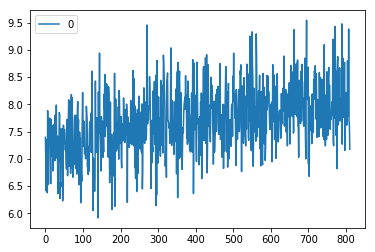

In [48]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [49]:
def translate(sent):
    senttoken = [en2ind[i.lower()] for i in sent.split()]
    senttoken.append(en2ind['<eos>'])
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    print(inputx,inputx_len)
    batch_translations = session.run(translations,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    print(batch_translations)
    for i in batch_translations:
        print(ind2ch[i])
    return ''.join([ind2ch[i] for i in batch_translations])

In [61]:
source_sentence = "I love shopping   ."

In [62]:
translate(source_sentence)

[[   7   84 1249    4    0]] [5]
[   5   87 1340  156    4    2]
我
爱
购
物
。
<end>


'我爱购物。<end>'

In [ ]:
! mkdir models

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(session,'models/seq2seq_model')

In [ ]:
! ls -l 'models/seq2seq_model.data-00000-of-00001'